# Meteorite Landings

Author: **Marcin Sikorski**<br/>
Date: November, 2022

Space and meteorites have always been fun topics. The fact that meteorites are extraterrestrial objects and travel humongous distances to reach our planet is fascinating. Many of them are very old, some dating from the early days of the Solar System. Meteorites are solid pieces of debris from outer space objects, such as comets, asteroids, or meteoroids, that survived its passage through the atmosphere to strike the surface of Earth.

This simple analysis aims to explore and practice geospatial visualizing with Python libraries. Figures were created with <code>cartopy</code> basemaps which allows us to visualize Earth's surface in more detail.

**Report content:**<br/>
1. Loading and Clearing Data<br/>
    1.1 Location Corrections<br/>
    1.2 Mass Corrections<br/>
    1.3 Year Corrections<br/>
2. Exploratory Data Analysis<br/>
    2.1 Categorical Data<br/>
    2.2 Mass Distribution<br/>
    2.3 Year Distrubution<br/>
3. Geospatial Visualization<br/>
    3.1 Mapping Location of the Most Massive Meteorite<br/>
    3.2 Mapping Meteorites Worldwide<br/>
    3.3 Mapping Landings in Europe By Class<br/>
    3.4 Mapping Heatmap of Landings in the United States<br/>
    3.5 Mapping Meteorites in Australia by Their Mass<br/>
4. Conclusions

**Dataset Description**

This dataset was provided by the Meteoritical Society on meteorites that have fallen to Earth. It includes the location, mass, composition, and fall year for over 45 000 meteorites that have struck our planet. The data were downloaded from [Kaggle](http://www.kaggle.com/nasa/meteorite-landings) and is originated to NASA's Data Portal.

In [1]:
# importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings('ignore')

### 1. Loading and Clearing Data

We can easily load our CSV file into one dataframe using <code>pandas</code>:

In [2]:
# loading data into single dataframe
df = pd.read_csv('meteorite-landings.csv', header=0)

# display first rows
df[:7]

,name,id,nametype,recclass,mass,fall,year,reclat,reclong,GeoLocation
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775000, 6.083330)"
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.183330, 10.233330)"
2,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.216670, -113.000000)"
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.883330, -99.900000)"
4,Achiras,370,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.166670, -64.950000)"
5,Adhi Kot,379,Valid,EH4,4239.0,Fell,1919.0,32.10000,71.80000,"(32.100000, 71.800000)"
6,Adzhi-Bogdo (stone),390,Valid,LL3-6,910.0,Fell,1949.0,44.83333,95.16667,"(44.833330, 95.166670)"


In the next step, we will print data types for each column and quantity of null (NaN) values.

In [3]:
# initialize new lists
null_list = []
types_list = []
for var in df.columns:
    null_list.append(df[var].isnull().sum())
    types_list.append(df[var].dtype)

# stack lists into dictionary
pd.DataFrame({'Variable': df.columns, 'Data type': types_list, 'Null values': null_list}).style.hide_index()

Variable,Data type,Null values
name,object,0
id,int64,0
nametype,object,0
recclass,object,0
mass,float64,131
fall,object,0
year,float64,288
reclat,float64,7315
reclong,float64,7315
GeoLocation,object,7315


1. We do not need all columns, so we will drop the least useful.
2. We will rename the header using shorter descriptions.
3. Also, we want to express meteorite mass in kilograms. The current column contains values in grams.
4. We will convert <code>year</code> column from float to integer. Before the conversion, we need to fill null values with zero's, otherwise the converting function will not wrok

In [4]:
# 1. drop columns from dataframe
df = df.drop(columns=['id', 'nametype', 'GeoLocation'])

# 2. rename columns using dictionary
df.rename(columns={'recclass': 'class', 'reclat': 'lat', 'reclong': 'long'}, inplace=True)

# 3. convert gr's into kg's
df['mass'] = df['mass'] / 1000

# 4. convert floats into ints
# in case 'year' column has blank values
df['year'] = df['year'].fillna(0)
df['year'] = df['year'].astype(int)

#### 1.1 Location Corrections

A note about missing or incorrect data points attached to the dataset advised to treat this type of data as NaN. We will filter out rows containg missing coordinates, since it is quite difficult to get the data and plotting these meteorites will be impossible.

In [5]:
# display rows with both zero or both NaN coordinates
df.query('(lat == 0 & long == 0) | (lat.isnull() & long.isnull())')

,name,class,mass,fall,year,lat,long
37,Northwest Africa 5815,L5,0.25680,Found,0,0.0,0.0
147,Bulls Run,Iron?,2.25000,Fell,1964,NaN,NaN
208,Clohars,L4,0.04860,Fell,1822,NaN,NaN
409,Jalanash,Ureilite,0.70000,Fell,1990,NaN,NaN
414,Jemlapur,L6,0.45000,Fell,1901,NaN,NaN
...,...,...,...,...,...,...,...
45657,Yamato 984146,H3,0.01932,Found,1998,0.0,0.0
45658,Yamato 984147,LL6,0.11890,Found,1998,0.0,0.0
45659,Yamato 984148,L5,0.00459,Found,1998,0.0,0.0
45660,Yambo no. 2,L3,0.00320,Found,1975,NaN,NaN


In [6]:
# extract indexes for these rows
indexes = df.query('(lat == 0 & long == 0) | (lat.isnull() & long.isnull())').index

# drop these rows
df = df.drop(indexes)

Latitude values should be in closed interval [-90, 90]. Merdians should be in interval (-180, 180]; not in [0, 360). We will check these ranges and do necessary adjustments.

In [7]:
# latitude interval
df.query('lat < -90 | lat > 90')

,name,class,mass,fall,year,lat,long


In [8]:
# longitude interval
df.query('long < -180 | long > 180')

,name,class,mass,fall,year,lat,long
22946,Meridiani Planum,"Iron, IAB complex",NaN,Found,2005,-1.94617,354.47333


In [9]:
# correct longitude for row 22946
df.at[22946, 'long'] = 360 - 354.47333

In [10]:
# display rows with latitude equal zero
df.query('lat == 0')

,name,class,mass,fall,year,lat,long
610,Meru,LL6,6.00000,Fell,1945,0.0,37.66667
38798,Yamato 74380,H5,0.00296,Found,1974,0.0,35.66667
38799,Yamato 74381,H5,0.00321,Found,1974,0.0,35.66667
38800,Yamato 74382,H5,0.00260,Found,1974,0.0,35.66667
38801,Yamato 74383,H5,0.00307,Found,1974,0.0,35.66667
...,...,...,...,...,...,...,...
39052,Yamato 74634,H6,0.00522,Found,1974,0.0,35.66667
39053,Yamato 74635,H6,0.00427,Found,1974,0.0,35.66667
39054,Yamato 74636,H6,0.00122,Found,1974,0.0,35.66667
39055,Yamato 74637,H6,0.00270,Found,1974,0.0,35.66667


Searching proved the Meru meteorite to be real - [source](https://www.lpi.usra.edu/meteor/metbull.php?code=15491). We will keep this row. The other Yamato instances seem to overlay each other and will be dropped.

In [11]:
# double check for rows with the exact coordinates - should be 223
df.query('lat == 0 & long == 35.66667')

,name,class,mass,fall,year,lat,long
38798,Yamato 74380,H5,0.00296,Found,1974,0.0,35.66667
38799,Yamato 74381,H5,0.00321,Found,1974,0.0,35.66667
38800,Yamato 74382,H5,0.00260,Found,1974,0.0,35.66667
38801,Yamato 74383,H5,0.00307,Found,1974,0.0,35.66667
38802,Yamato 74384,H5,0.00300,Found,1974,0.0,35.66667
...,...,...,...,...,...,...,...
39052,Yamato 74634,H6,0.00522,Found,1974,0.0,35.66667
39053,Yamato 74635,H6,0.00427,Found,1974,0.0,35.66667
39054,Yamato 74636,H6,0.00122,Found,1974,0.0,35.66667
39055,Yamato 74637,H6,0.00270,Found,1974,0.0,35.66667


In [12]:
# extract indexes for these rows
indexes = df.query('lat == 0 & long == 35.66667').index

# drop these rows (by indexes)
df = df.drop(indexes)

In [13]:
# display rows with longitude equal zero
df.query('long == 0')

,name,class,mass,fall,year,lat,long


The dataset should be clean in terms of geospatial data.

#### 1.2 Mass Corrections

For the next step, we will investigate <code>mass</code> column.

In [14]:
# display rows with zero mass
df.query('mass == 0')

,name,class,mass,fall,year,lat,long
12627,Gove,Relict iron,0.0,Found,1979,-12.26333,136.83833
31060,Österplana 048,Relict OC,0.0,Found,2004,58.58333,13.43333
31061,Österplana 049,Relict OC,0.0,Found,2012,58.58333,13.43333
31062,Österplana 050,Relict OC,0.0,Found,2003,58.58333,13.43333
31063,Österplana 051,Relict OC,0.0,Found,2006,58.58333,13.43333
31064,Österplana 052,Relict OC,0.0,Found,2006,58.58333,13.43333
31065,Österplana 053,Relict OC,0.0,Found,2002,58.58333,13.43333
31066,Österplana 054,Relict OC,0.0,Found,2005,58.58333,13.43333
31067,Österplana 055,Relict OC,0.0,Found,2008,58.58333,13.43333
31068,Österplana 056,Relict OC,0.0,Found,2008,58.58333,13.43333


The Gove meteorite, in first row, is authentic and was found in an open cut mine on the Gove Peninsula in Australia - [source](https://www.lpi.usra.edu/meteor/metbull.php?code=52859). Its mass is unknown and will be kept. The other meteorites look like mistakenly collected.

In [15]:
# display more rows with the exact coordinates
df.query('long == 58.58333 | long == 13.43333')

,name,class,mass,fall,year,lat,long
31013,Osterplana,Relict OC,NaN,Found,1987,58.58333,13.43333
31014,Österplana 002,Relict OC,NaN,Found,1993,58.58333,13.43333
31015,Österplana 003,Relict OC,NaN,Found,1993,58.58333,13.43333
31016,Österplana 004,Relict OC,NaN,Found,1994,58.58333,13.43333
31017,Österplana 005,Relict OC,NaN,Found,1990,58.58333,13.43333
...,...,...,...,...,...,...,...
31072,Österplana 060,Relict OC,0.0,Found,2009,58.58333,13.43333
31073,Österplana 061,Relict OC,0.0,Found,2009,58.58333,13.43333
31074,Österplana 062,Relict OC,0.0,Found,2010,58.58333,13.43333
31075,Österplana 063,Relict OC,0.0,Found,2010,58.58333,13.43333


In [16]:
# drop these rows by their indexes
for i in range (31013, 31077):
    df = df.drop(axis=0, index=i)

In [17]:
# display rows with NaN mass
df.query('mass.isnull()')

,name,class,mass,fall,year,lat,long
12,Aire-sur-la-Lys,Unknown,NaN,Fell,1769,50.66667,2.33333
38,Angers,L6,NaN,Fell,1822,47.46667,-0.55000
76,Barcelona (stone),OC,NaN,Fell,1704,41.36667,2.16667
93,Belville,OC,NaN,Fell,1937,-32.33333,-64.86667
172,Castel Berardenga,Stone-uncl,NaN,Fell,1791,43.35000,11.50000
...,...,...,...,...,...,...,...
36812,San Luis,H,NaN,Found,1964,-33.33333,-66.38333
38188,Ur,Iron,NaN,Found,2501,30.90000,46.01667
38278,Weiyuan,Mesosiderite,NaN,Found,1978,35.26667,104.31667
41460,Yamato 792768,CM2,NaN,Found,1979,-71.50000,35.66667


Although these meteorites do not have masses, we still can visualize them on basemaps. At first glance, the coordinates do not look suspicious. We will save these rows.

#### 1.3 Year Corrections

The last step of data cleansing will cover <code>year</code> column checking. We already know from the starting that it may contain NaN values - any possible null values were replaced by zeros prior converting the column to integers. We will start by displaying the distribution for last 15 years in our dataset.

In [18]:
# checking the data distribution of last 15 years
df.groupby('year').count().tail(15)

,name,class,mass,fall,lat,long
year,,,,,,
2000,1497,1497,1495,1497,1497,1497
2001,1286,1286,1286,1286,1286,1286
2002,1025,1025,1025,1025,1025,1025
2003,1713,1713,1713,1713,1713,1713
2004,263,263,263,263,263,263
2005,245,245,244,245,245,245
2006,1221,1221,1221,1221,1221,1221
2007,236,236,236,236,236,236
2008,259,259,259,259,259,259


There is practically no data after 2013. We will extract a subset of data for further work. We are interested in meteorites which struck Earth after 1800. Since we will select a range of years, further investigating <code>year</code> column has no sense.

In [19]:
# filter out new data
data = df.query('year > 1799 & year < 2014')

# display first rows
data[:7]

,name,class,mass,fall,year,lat,long
0,Aachen,L5,0.021,Fell,1880,50.77500,6.08333
1,Aarhus,H6,0.720,Fell,1951,56.18333,10.23333
2,Abee,EH4,107.000,Fell,1952,54.21667,-113.00000
3,Acapulco,Acapulcoite,1.914,Fell,1976,16.88333,-99.90000
4,Achiras,L6,0.780,Fell,1902,-33.16667,-64.95000
5,Adhi Kot,EH4,4.239,Fell,1919,32.10000,71.80000
6,Adzhi-Bogdo (stone),LL3-6,0.910,Fell,1949,44.83333,95.16667


### 2. Exploratory Data Analysis

Now that our new dataframe is ready, it is time to look up for some detail and information about it.

#### 2.1 Categorical Data

Lets start from plotting top 15 meteorite classes (in terms of quantity).

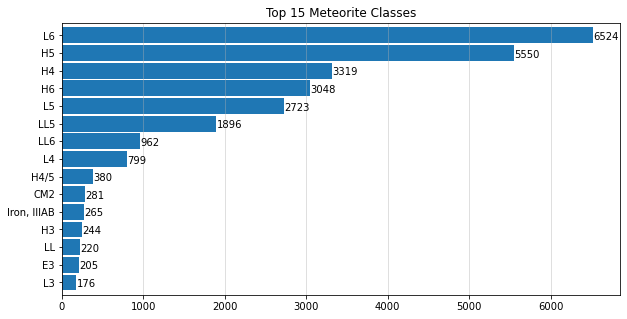

In [20]:
# create list of labels
class_labels = data['class'].value_counts().head(15).tolist()

# horizontal bar plot
data['class'].value_counts().head(15).plot(kind='barh', title='Top 15 Meteorite Classes', width=0.9, figsize=(10, 5))
plt.grid(axis='x', alpha=0.5)
plt.gca().invert_yaxis()

# add count values from list
for i, v in enumerate(class_labels):
    plt.text(x=v+3, y=i+0.25, s=str(v))
    
plt.show()

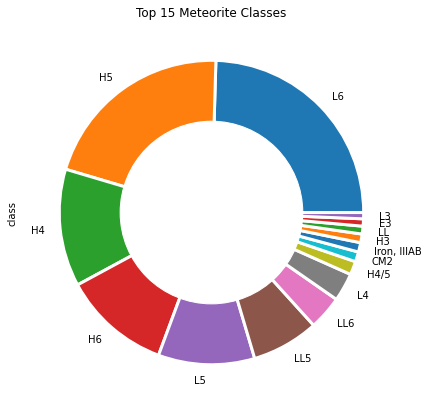

In [21]:
# extract dataset by labels
meteo_class = data['class'].value_counts().head(15)

# pie plot
meteo_class.plot(kind='pie', title='Top 15 Meteorite Classes', figsize=(7, 7))
plt.pie(meteo_class, wedgeprops = {'linewidth': 3, 'edgecolor': 'white'})

# insert circle
circle = plt.Circle((0, 0), 0.6, color='white')
plt.gcf().gca().add_artist(circle)
plt.show()

In [22]:
# show unique labels and quantity in percent
class_labels = data['class'].value_counts(normalize=True).head(15)

pd.DataFrame({'Class [%]': round(class_labels*100, 1)})

,Class [%]
L6,20.6
H5,17.5
H4,10.5
H6,9.6
L5,8.6
LL5,6.0
LL6,3.0
L4,2.5
H4/5,1.2
CM2,0.9


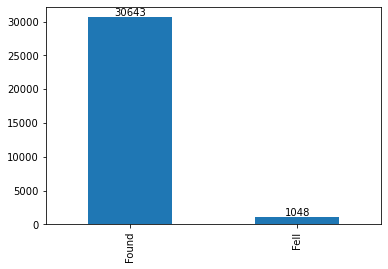

In [23]:
# create list of labels
fall_labels = data['fall'].value_counts().tolist()

# bar plot - 'fall' labels
data['fall'].value_counts().plot.bar()

# add count values from list
for i, v in enumerate(fall_labels):
    plt.text(x=i, y=v, s=str(v), ha='center', va='bottom')

plt.show()

In [24]:
# show unique labels and quantity in percent
fall_labels = round(data['fall'].value_counts(normalize=True)*100, 1)

pd.DataFrame({'Fall [%]': fall_labels})

,Fall [%]
Found,96.7
Fell,3.3


#### 2.2 Mass Distribution

Lets plot meteorites distribution by <code>mass</code>. A simple histogram with logarithmic scales should be able to reveal this. We will also plot <code>mass</code> versus <code>year</code>.

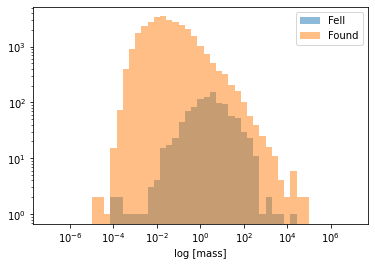

In [25]:
# histogram by 'fall' labels
falls = data.groupby('fall')

for name, group in falls:
    plt.hist(x=group['mass'], bins=10**np.linspace(-7, 7), alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log [mass]')
plt.legend(['Fell','Found'])
plt.show()

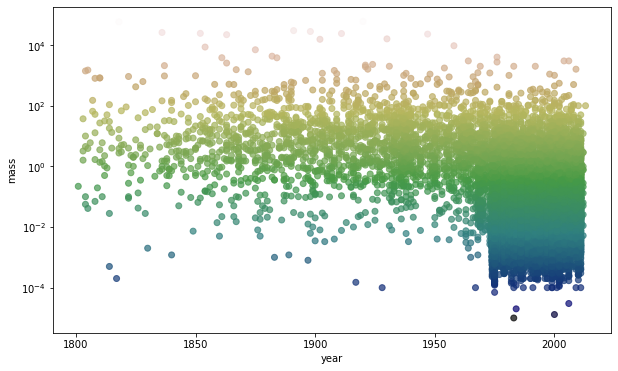

In [26]:
# scatter plot - meteorite mass vs. year
plt.figure(figsize=(10, 6))
plt.scatter(x=data['year'], y=data['mass'], c=np.log10(data['mass']), cmap='gist_earth', alpha=0.7)
plt.yscale('log')
plt.xlabel('year')
plt.ylabel('mass')
plt.show()

#### 2.3 Year Distrubution

We will plot the meteorite distribution recorded by year of discovery.

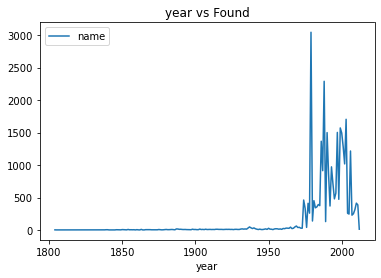

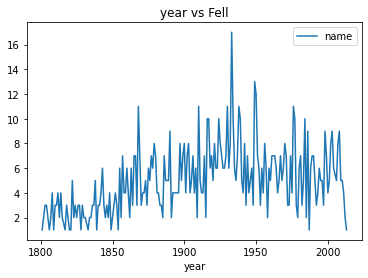

In [27]:
# plot by 'fall' label
for i in ['Found', 'Fell']:
    pd.pivot_table(data[data['fall'] == i], index='year', values='name', aggfunc='count').plot(title='year vs {}'.format(i))
    plt.show()

Higher interest of meteorite researching is observed after 1970. Far less meteorites were witnessed during their fall.

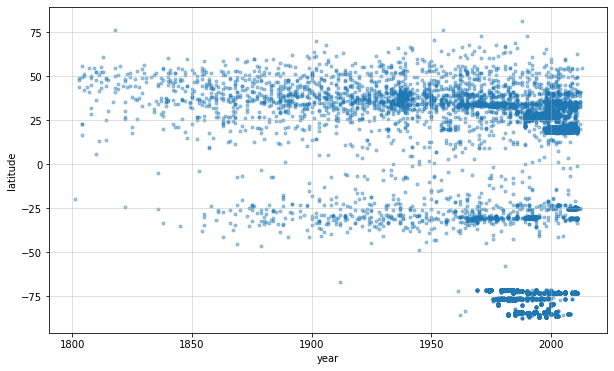

In [28]:
# scatter plot - latitude vs. year
plt.figure(figsize=(10, 6))
plt.scatter(x=data['year'], y=data['lat'], alpha=0.4, marker='.')
plt.xlabel('year')
plt.ylabel('latitude')
plt.grid(visible=True, alpha=0.5)
plt.show()

The above figure shows meteorite latitude sites versus year. Far more meteorites fall to the Northern Hemisphere. Both Hemispheres are more often besieged around 25th parallels.

It is also interesting that in the Southern Hemisphere, at latitude 75&deg;, meteorites began to be found since the 1960s. These regions on the world map correspond to Antarctica and it was in the 1960s that scientific research began on a larger scale on this land.

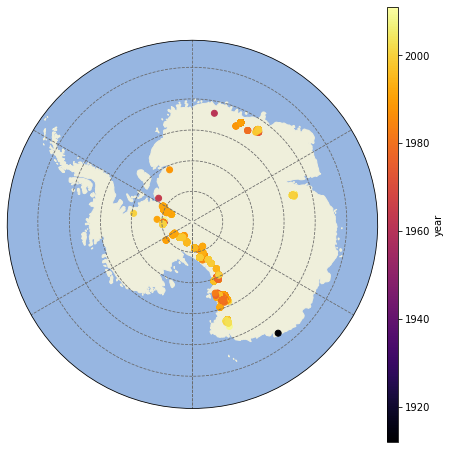

In [29]:
# new subset of data for Antarctica
antarctica = data.query('lat < -60')

# overview plot
fig = plt.figure(figsize=(8, 8))

# output projection
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

# add map features
ax.gridlines(color='dimgray', linestyle='--')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)

import matplotlib.path as mpath

# compute circular boundaries
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts*radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

# plot markers
plt.scatter(x=antarctica['long'], y=antarctica['lat'], c=antarctica['year'], marker='o',
            cmap='inferno', transform=ccrs.PlateCarree())

plt.colorbar(pad=0.02, aspect=40, orientation='vertical', label='year')
plt.show()

Antarctica is based on South Pole and using a polar projection is an absolute necessary. This plot provides much better overview on the continent. Marker colors clearly show the conclusion from the previous chart. There is one black point indicating that it was recorded before 1920.

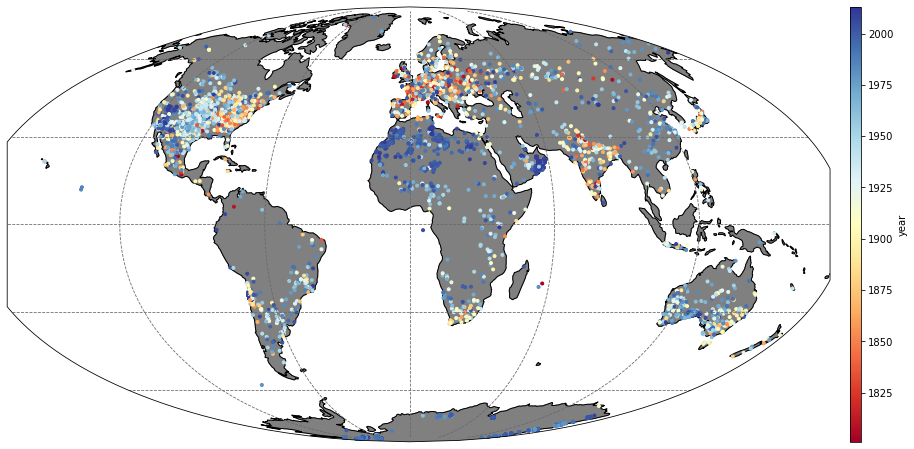

In [30]:
# overview plot
fig = plt.figure(figsize=(18, 8))

# output projection
ax = plt.axes(projection=ccrs.Mollweide(central_longitude=0))

# add map features
ax.gridlines(color='dimgray', linestyle='--')
ax.coastlines(resolution='110m')
ax.add_feature(cfeature.LAND, color='grey')

# scatter plot by year
plt.scatter(x=data['long'], y=data['lat'], c=data['year'], marker='.', cmap='RdYlBu', transform=ccrs.PlateCarree())

plt.colorbar(pad=0.02, aspect=40, orientation='vertical', label='year')
plt.show()

A worldwide scatter plot with Mollweide projection looks a little messy due to its distortion (equal-area properties). The figure displays higher point density in the Northern Hemisphere over lower. We will try another plot with different projection.

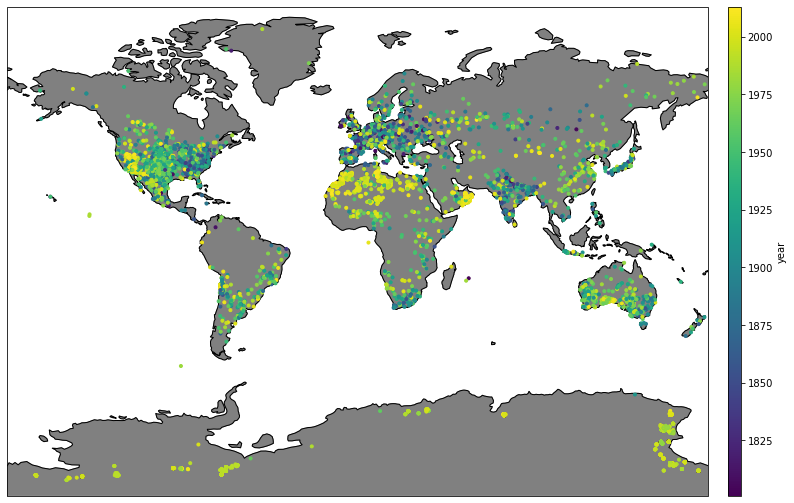

In [31]:
# another scatter plot
fig = plt.figure(figsize=(18, 9))

# output projection
ax = plt.axes(projection=ccrs.Miller(central_longitude=0))

# add map features
ax.coastlines(resolution='110m')
ax.add_feature(cfeature.LAND, color='grey')

# scatter plot by year
plt.scatter(x=data['long'], y=data['lat'], c=data['year'], marker='.', cmap='viridis', transform=ccrs.PlateCarree())

plt.colorbar(pad=0.02, aspect=40, orientation='vertical', label='year')
plt.show()

Much more data was collected after 1970, as indicated by green and yellow markers. Soon we will plot these points on the world map for better insights.

### 3. Geospatial Visualization

This is the main stage of this notebook. We will plot different thematic maps for different regions of our globe.

#### 3.1 Mapping Location of the Most Massive Meteorite

Using <code>cartopy</code> we will map the point where the biggest meteorite struck.

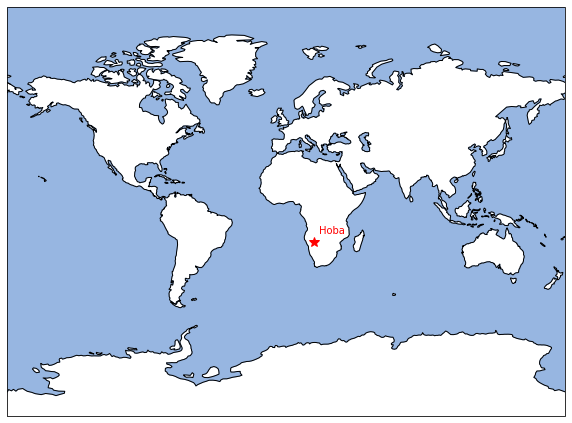

In [32]:
# overview plot
fig = plt.figure(figsize=(10, 8))

# output projection
ax = plt.axes(projection=ccrs.Miller(central_longitude=0))
ax.set_extent([-180, 180, 90, -90], ccrs.PlateCarree())

# add map features
ax.coastlines(resolution='110m')
ax.add_feature(cfeature.OCEAN)

# extract heaviest meteorite data into list
max_meteorite = []
for i in ['lat', 'long', 'name', 'year']:
    max_meteorite.append(data[i].loc[data['mass'].idxmax()])

# plot marker
plt.plot(max_meteorite[1], max_meteorite[0], marker='*', ms='10', c='red')

# add label
plt.text(x=max_meteorite[1]+20, y=max_meteorite[0]+5, s=max_meteorite[2], horizontalalignment='right', color='red')
plt.show()

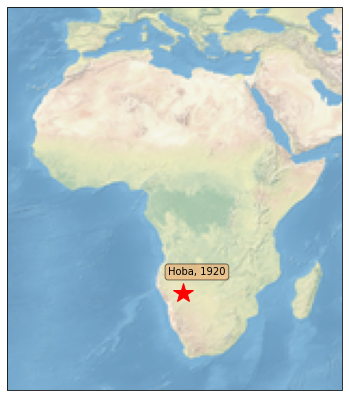

In [33]:
# zoomed view
fig = plt.figure(figsize=(6, 8))

# output projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-23, 55, -35, 40])

# add map features
ax.stock_img()

# extract heaviest meteorite data into list
max_meteorite = []
for i in ['lat', 'long', 'name', 'year']:
    max_meteorite.append(data[i].loc[data['mass'].idxmax()])

# plot marker
plt.plot(max_meteorite[1], max_meteorite[0], marker='*', ms='20', c='red')

# add text box
plt.text(x=max_meteorite[1]+10, y=max_meteorite[0]+5, s='{}, {}'.format(max_meteorite[2], max_meteorite[3]),
         verticalalignment='center', horizontalalignment='right',
         bbox=dict(facecolor='sandybrown', alpha=0.5, boxstyle='round'))
plt.show()

In [34]:
# display more detail about this meteorite
pd.DataFrame(data.loc[data['mass'].idxmax()]).transpose()

# optional
#data[data['mass'] == data['mass'].max()]

,name,class,mass,fall,year,lat,long
16383,Hoba,"Iron, IVB",60000.0,Found,1920,-19.58333,17.91667


#### 3.2 Mapping Meteorites Worldwide

We will plot points grouping by <code>fall</code> variable. There are only two labels in the column: **fell** (meteorites that were witnessed during their fall) and **found** (meteorites that were discovered many years later).

In [35]:
# color function categorizing points by 'fall'
def marker_color(fall):
    if fall == 'Fell':
        return 'red'
    elif fall == 'Found':
        return 'orange'
    else:
        return 'blue'

# create new color list
color_list = [marker_color(discovery_type) for discovery_type in data['fall']]

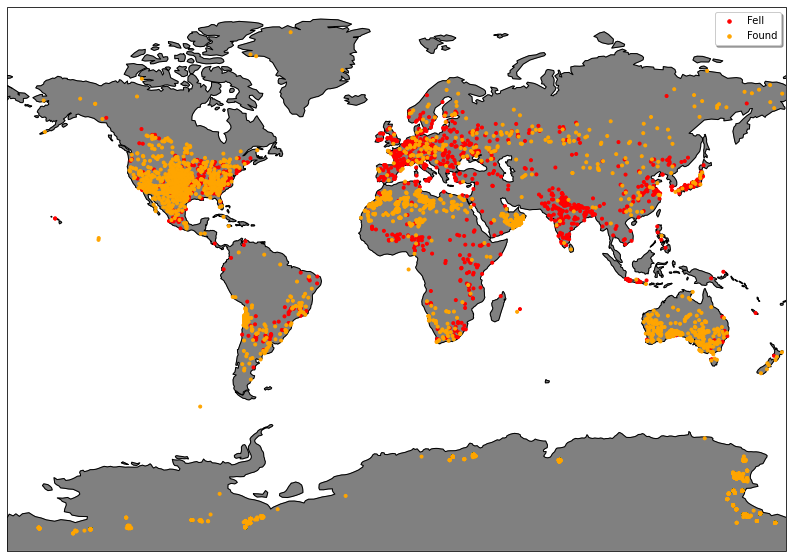

In [36]:
# worldwide scatter plot
fig = plt.figure(figsize=(18, 10))

# output projection
ax = plt.axes(projection=ccrs.Miller(central_longitude=0))

# add map features
ax.coastlines(resolution='110m')
ax.add_feature(cfeature.LAND, color='grey')

# scatter plot by discovery
plt.scatter(x=data['long'], y=data['lat'], marker='.', c=color_list, transform=ccrs.PlateCarree())

# create legend
from matplotlib.lines import Line2D

legend_elements = [Line2D([0],[0], color='red', marker='.', linestyle='None', markersize=7, label='Fell'),
                   Line2D([0],[0], color='orange', marker='.', linestyle='None', markersize=7, label='Found')]
plt.legend(handles=legend_elements, loc='upper right', title=None, ncol=1, shadow=True)
plt.show()

It is not surprising that much more meteorites are observed in inhabitant regions. Wild geographic lands are far more less dense such as: Amazon forests, the Arctic, Russian tayga, and North Canada. The deserts are an exception as we can see loads of **found** meteorites (Sahara, Atacama, or Mojave). Searching for meteorites in forested areas must be far more difficult than in open areas. There are no points in dataset gathered about meteorites in water bodies. It is also easy to spot that the most meteorites are found in the US. That is beacause the Meteoritical Society is based in that country and most likely is the main region of interest.

This figure gives a nice overview of overall densities but because of their numbers there is also a lot of overlap between data points. We can will combine discovery type and mass for each meteorite in the following bubble plot.

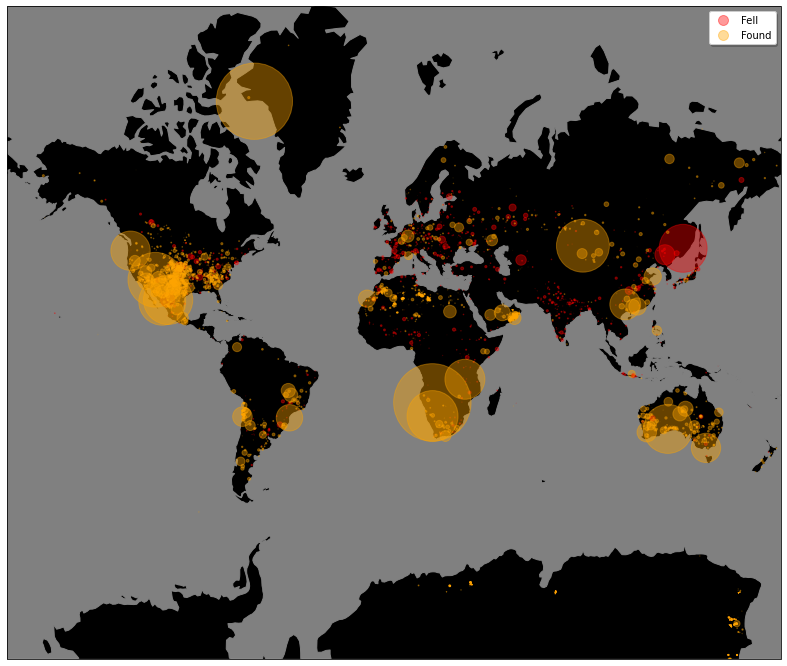

In [37]:
# combined bubble plot
fig = plt.figure(figsize=(18, 12))

# output projection
ax = plt.axes(projection=ccrs.Mercator(central_longitude=0))

# add map features
ax.add_feature(cfeature.LAND, color='black')
ax.add_feature(cfeature.OCEAN, color='grey')

# bubble plot by discovery and mass
plt.scatter(x=data['long'], y=data['lat'], s=data['mass']/10, c=color_list, alpha=0.4, transform=ccrs.PlateCarree())

# create legend
legend_elements = [Line2D([0],[0], color='red', marker='o', linestyle='None', markersize=10, alpha=0.4, label='Fell'),
                   Line2D([0],[0], color='orange', marker='o', linestyle='None', markersize=10, alpha=0.4, label='Found')]
plt.legend(handles=legend_elements, loc='upper right', title=None, ncol=1, shadow=True)
plt.show()

#### 3.3 Mapping Landings in Europe By Class

As next step, we will visualize landings in Europe for the 10 most numerous meteorite classes. To get these classes, we need to implement the following steps:
* group by all classes, aggregate values with a count function, and order the quantity descending;
* extract the classes (indexes) into a list;
* filter rows by values contained in new list.

In [38]:
# 10 top classes in dataset
data.groupby('class').agg('count').sort_values(by='name', ascending=False).head(10)

,name,mass,fall,year,lat,long
class,,,,,,
L6,6524,6518,6524,6524,6524,6524
H5,5550,5546,5550,5550,5550,5550
H4,3319,3319,3319,3319,3319,3319
H6,3048,3048,3048,3048,3048,3048
L5,2723,2721,2723,2723,2723,2723
LL5,1896,1896,1896,1896,1896,1896
LL6,962,962,962,962,962,962
L4,799,799,799,799,799,799
H4/5,380,380,380,380,380,380


In [39]:
# extract indexes into list
data.groupby('class').agg('count').sort_values(by='name', ascending=False).head(10).index.values.tolist()

['L6', 'H5', 'H4', 'H6', 'L5', 'LL5', 'LL6', 'L4', 'H4/5', 'CM2']

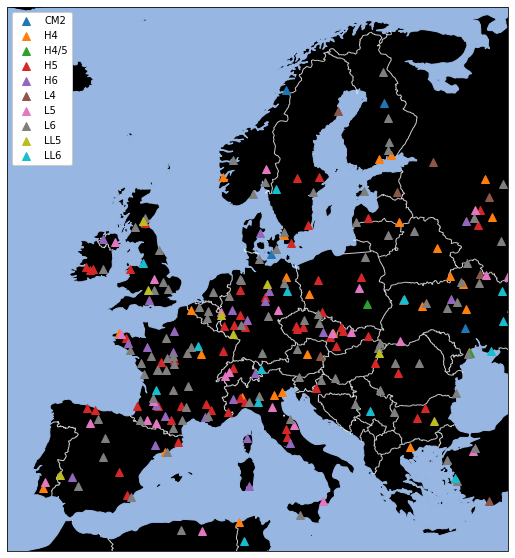

In [40]:
# meteorite landings in Europe by top 10 classes
fig = plt.figure(figsize=(12, 10))

# output projection
proj = ccrs.AlbersEqualArea(central_latitude=0, false_easting=0, false_northing=0, central_longitude=10,
                            standard_parallels=(35, 50))
ax = plt.axes(projection=proj)
ax.set_extent([-10, 30, 33, 72])

# add map features
ax.add_feature(cfeature.LAND, color='black')
ax.add_feature(cfeature.OCEAN)
bodr = cfeature.NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='10m',
                                    facecolor='none', alpha=0.7)
ax.add_feature(bodr, linestyle='-', edgecolor='white', alpha=0.8)

# repeat steps
class_list = data.groupby('class').agg('count').sort_values(by='name', ascending=False).head(10).index.values.tolist()
class_subset = data[data['class'].isin(class_list)]

# scatter plot for top classes
classes = class_subset.groupby('class')
for name, group in classes:
    plt.plot(group.long, group.lat, marker='^', linestyle='', markersize=8, label=name, transform=ccrs.PlateCarree())

plt.legend(framealpha=1)
plt.show()

#### 3.4 Mapping Heatmap of Landings in the United States

At this stage, we will visualize the density of landings in the United States. For this task we will combine a bivariate KDE (kernel distribution estimation) plot with a projected basemap. The density will be expressed with a custom colormap.

In [41]:
# create custom colormap
import matplotlib.colors as clr

cmap = clr.LinearSegmentedColormap.from_list('custom cmap', ['#9dcc42', '#fffe03', '#f7941d', '#e9420e', '#ff0000'], 256)

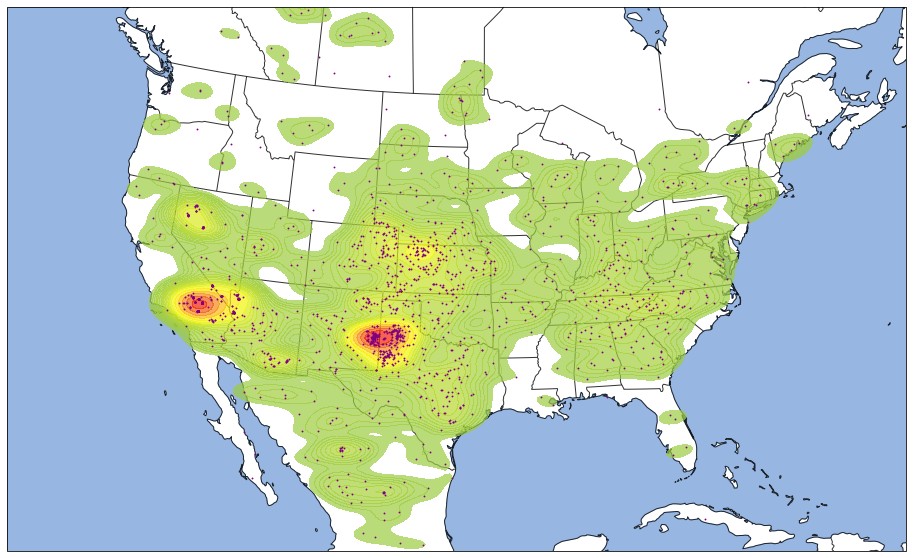

In [42]:
# heatmap of meteorite landings in the USA
from seaborn import kdeplot

# new subset of data for the USA
usa = data.query('lat > 21 & lat < 54 & long < -67 & long > -127')

# overview plot
fig = plt.figure(figsize=(18, 10))

# output projection
proj = ccrs.LambertConformal(central_latitude=25, central_longitude=265, standard_parallels=(25, 25))
ax = plt.axes(projection=proj)
ax.set_extent([-127, -67, 18, 50])

# add map features
ax.add_feature(cfeature.OCEAN)
bodr = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines',
                                    scale='50m', facecolor='none')
ax.add_feature(bodr, linestyle='-', edgecolor='black', alpha=0.8)
ax.coastlines('50m', edgecolor='black', alpha=0.8)
ax.add_feature(cfeature.BORDERS, edgecolor='black', alpha=0.8)

# density plot
kdeplot(x=usa['long'], y=usa['lat'], shade=True, shade_lowest=False, levels=20, bw=0.1, cmap=cmap,
        alpha=0.7, cbar=False, transform=ccrs.PlateCarree())

# meteorite strikes
plt.scatter(x=usa['long'], y=usa['lat'], s=3, marker='.', c='purple', transform=ccrs.PlateCarree())
plt.show()

The above map shows us the continental density with a heatmap. The most dense and hazardous areas are in Southern California and New Mexico - Texas border. In general, the center part of the country is the most sieged by these objects.

#### 3.5 Mapping Meteorites in Australia by Their Mass

Last plots will visualize meteorite sites in Australia according to <code>mass</code>.

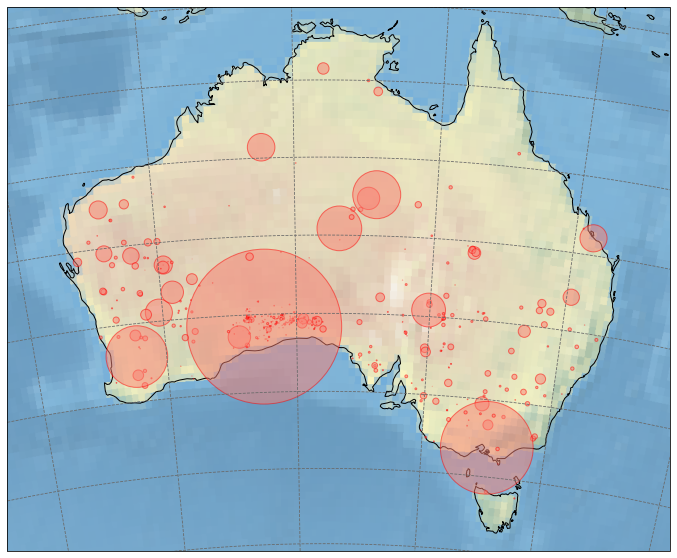

In [43]:
# figure 1 - circles (one color)
plt.figure(figsize=(12, 10))

# output projection
proj = ccrs.AlbersEqualArea(central_latitude=0, false_easting=0, false_northing=0, central_longitude=132,
                            standard_parallels=(-18, -36))
ax = plt.axes(projection=proj)
ax.set_extent([112, 154, -44, -9])

# add map features
ax.stock_img()
ax.coastlines(resolution='50m')
ax.gridlines(color='dimgray', linestyle='--')

# bubble plot
plt.scatter(x=data['long'], y=data['lat'], s=data['mass'], marker='o', alpha=0.5, linewidths=1, c='salmon',
            edgecolors='red', transform=ccrs.PlateCarree())
plt.show()

This bubble plot shows a very basic method of presenting meteorite masses. The circles are monocolored and masses are distinguished only by their radiuses. The next figure will combine highlight values by colors and radius lengths.

We will initialize our own function assigning colors by mass ranges. Colors will be identified in hex codes. Adding more circle colors makes it easier to identify meteorite mass and read the plot. Mass is also represented by circle radius - the most massive will obviously the largest radius.

In [44]:
# hex color function categorizing points by mass range
def circle_color(mass):
    if mass < 10:
        return '#1f77b4'
    elif mass in range(10, 200):
        return '#ff7f0e'
    elif mass in range(200, 500):
        return '#2ca02c'
    elif mass in range(500, 2000):
        return '#d62728'
    elif mass in range(2000, 5000):
        return '#9467bd'
    else:
        return '#8c564b'

# create new color list
mass_color_list = [circle_color(mass_type) for mass_type in data['mass']]

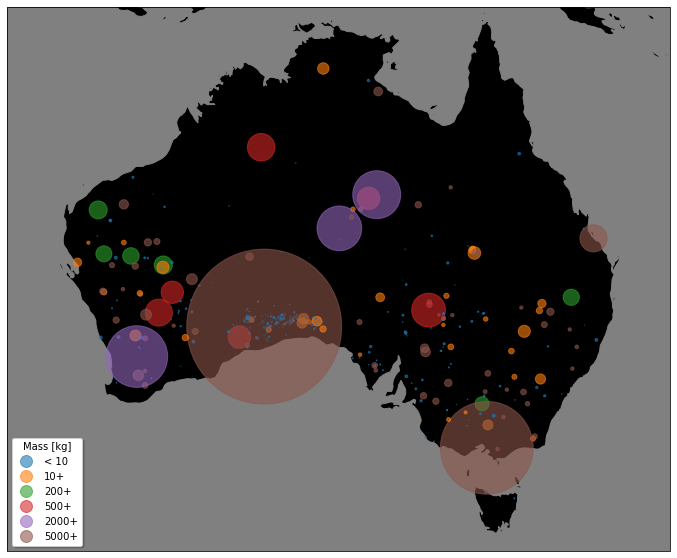

In [45]:
# figure 2 - customized circles (according to colormap function)
plt.figure(figsize=(12, 10))

# output projection
proj = ccrs.AlbersEqualArea(central_latitude=0, false_easting=0, false_northing=0, central_longitude=132,
                            standard_parallels=(-18, -36))
ax = plt.axes(projection=proj)
ax.set_extent([112, 154, -44, -9])

# add map features
ax.add_feature(cfeature.LAND, color='black')
ax.add_feature(cfeature.OCEAN, color='grey')

# bubble plot
plt.scatter(x=data['long'], y=data['lat'], s=data['mass'], marker='o', c=mass_color_list,
            alpha=0.6, edgecolors='face', transform=ccrs.PlateCarree())

# create legend
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
labels = ['< 10', '10+', '200+', '500+', '2000+', '5000+']

legend_elements = []
for i, j in zip(colors, labels):
    legend_elements.append(Line2D([0],[0], color=i, marker='o', linestyle='None',markersize=12, alpha=0.6, label=j))

plt.legend(handles=legend_elements, loc='lower left', title='Mass [kg]', ncol=1, shadow=True)
plt.show()

In [46]:
# display top heaviest meteorites in Australia
df.query('lat < -9 & lat > -44 & long > 112 & long < 154').sort_values(by='mass', ascending=False).head(5)

,name,class,mass,fall,year,lat,long
26293,Mundrabilla,"Iron, IAB-ung",24000.0,Found,1911,-30.78333,127.55000
5576,Cranbourne,"Iron, IAB-MG",8600.0,Found,1854,-38.10000,145.30000
45684,Youndegin,"Iron, IAB-MG",3800.0,Found,1884,-32.10000,117.71667
16405,Huckitta,"Pallasite, PMG-an",2300.0,Found,1924,-22.36667,135.76667
16369,Henbury,"Iron, IIIAB",2000.0,Found,1931,-24.56667,133.16667


### 4. Conclusions

A meteorite landings visualization was made to present temporal and geographic distribution of their landing sites. Thematic maps were plotted based on their features in the dataset - mass, discovery type, class. From the geospatial visualization, it is easy to assume that the distribution of meteorite landings is correlated to particular regions and events.

First, we prepared and cleaned our dataset and then displayed its overall analysis: by class, mass, and year distribution. Next, we proceeded to the main content of this notebook which was geospatial visualizing with <code>cartopy</code>.

Developing this analysis and visualitazion of meteorite landings was fun, yet challenging. This project showed interesting phenomenons. The <code>cartopy</code> library is great a expansion for <code>Matplotlib</code> for dealing with location-based data and makes geographic data visualizing easy. It also serves us a lot of possibilities in providing map projections and showing Earth's surface. This module gives us a clear overview of meteorite landings worldwide.